In [1]:
%matplotlib inline

import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [11]:
rating_file_path = "ratings.dat"
movie_file_path = "movies.dat"
user_file_path = "users.dat"

rating_data = pd.io.parsers.read_csv(rating_file_path, names=['user_id', 'movie_id', 'rating', 'time'], 
                                     delimiter='::', encoding='ISO-8859-1')
movie_data = pd.io.parsers.read_csv(movie_file_path, names=['movie_id', 'title', 'genre'], 
                                    delimiter='::', encoding='ISO-8859-1')
user_data = pd.io.parsers.read_csv(user_file_path, names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], 
                                   delimiter='::', encoding='ISO-8859-1')

In [12]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [13]:
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
user_data.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [15]:
print(rating_data.isnull().sum())
print(movie_data.isnull().sum())
print(user_data.isnull().sum())

user_id     0
movie_id    0
rating      0
time        0
dtype: int64
movie_id    0
title       0
genre       0
dtype: int64
user_id       0
gender        0
age           0
occupation    0
zipcode       0
dtype: int64


In [16]:
print("total number of movie in data :", len(movie_data['movie_id'].unique()))

movie_data['year'] = movie_data['title'].apply(lambda x: x[-5:-1])
movie_data['year'].value_counts().head(10)

total number of movie in data : 3883


1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

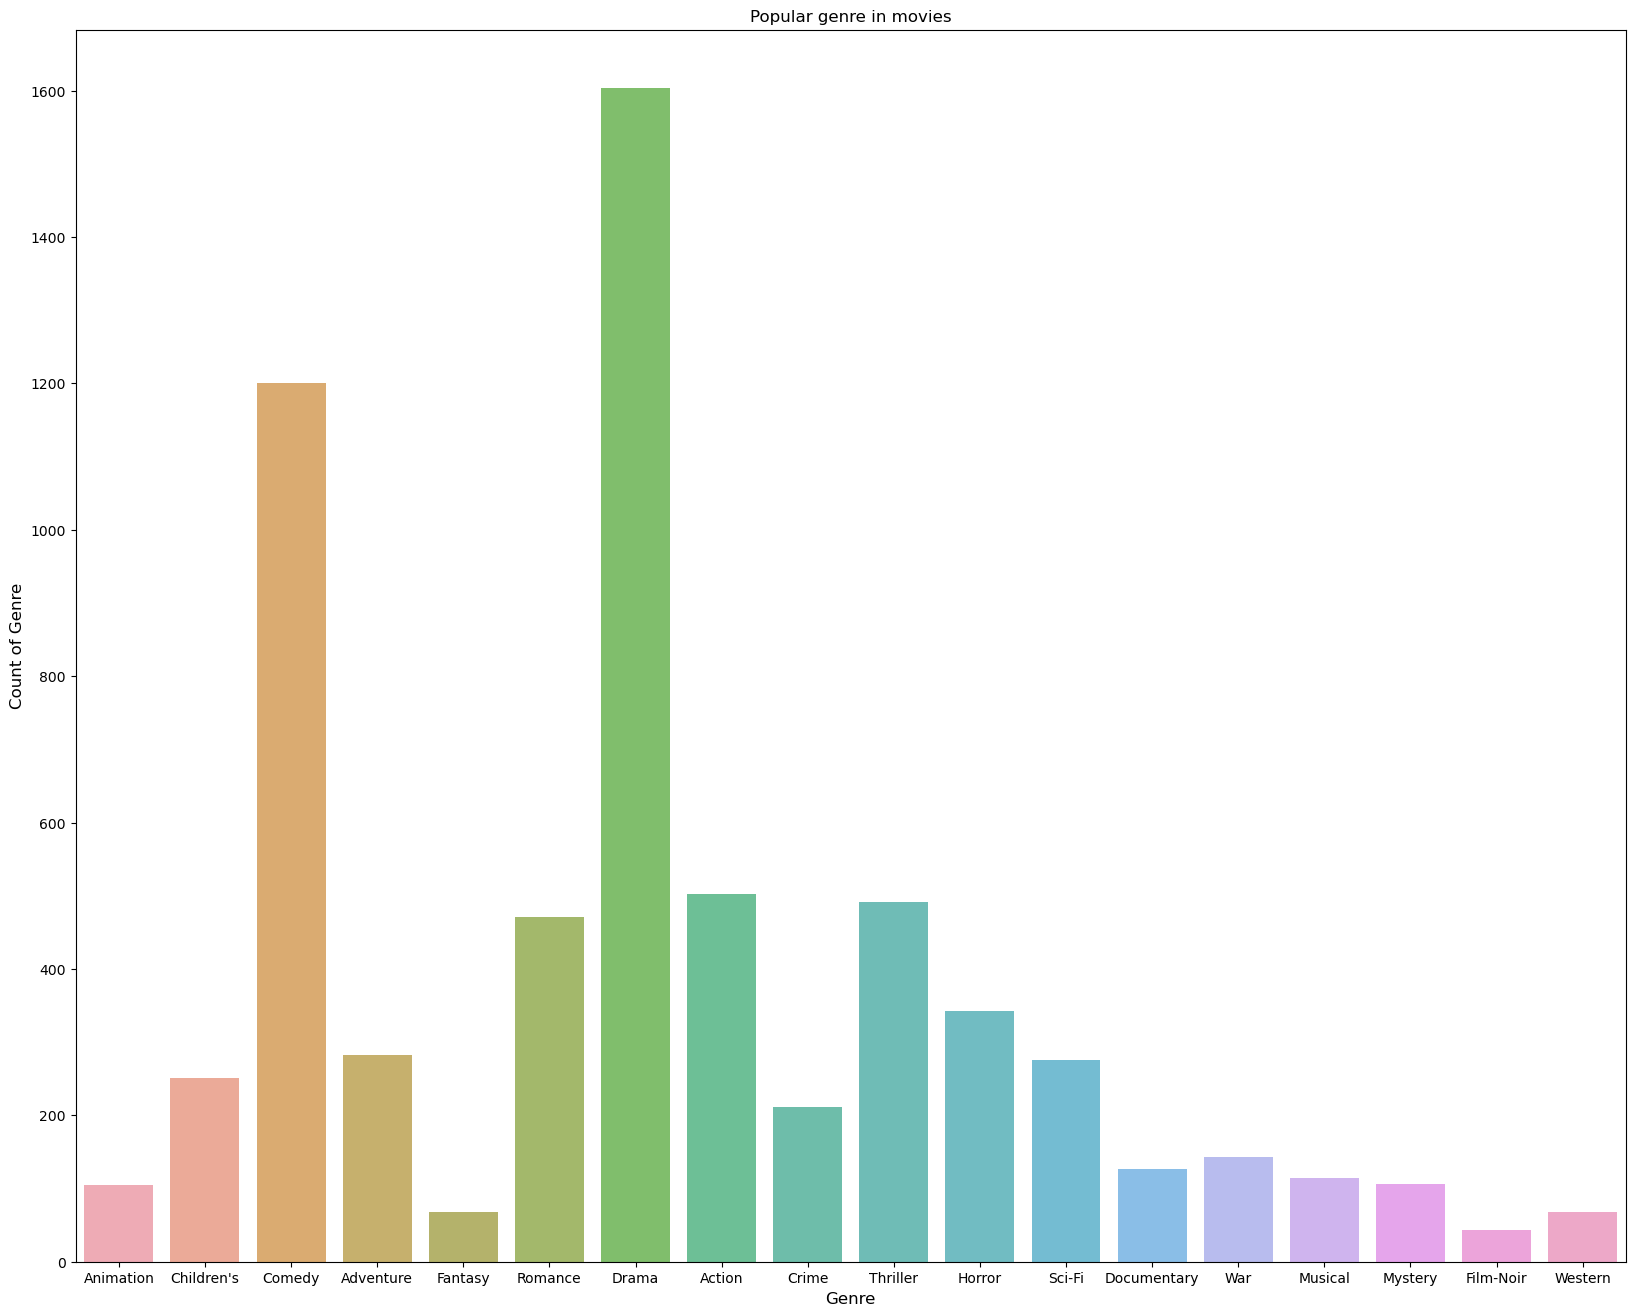

In [21]:
unique_genre_dict = {}
for index, row in movie_data.iterrows():
    genre_combination = row['genre']
    parsed_genre = genre_combination.split("|")
    
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1
            
plt.rcParams['figure.figsize'] = [20, 16]
sns.barplot(x = list(unique_genre_dict.keys()), 
            y = list(unique_genre_dict.values()), alpha=0.8)
plt.title('Popular genre in movies')
plt.ylabel('Count of Genre', fontsize = 12)
plt.xlabel('Genre', fontsize = 12)
plt.show()

In [22]:
print("total number of user in data :", len(user_data['user_id'].unique()))

total number of user in data : 6040


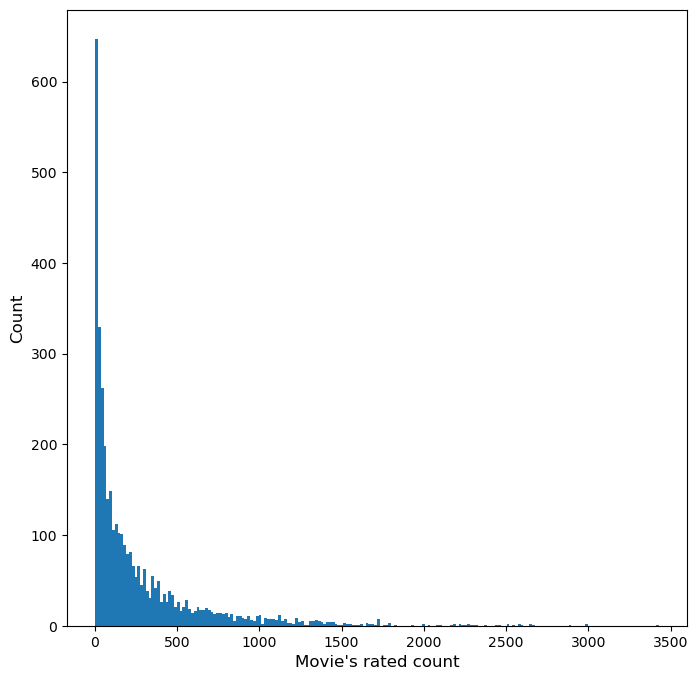

In [23]:
movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values
plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

In [31]:
movie_grouped_rating_info = rating_data.groupby("movie_id")['rating'].agg(['count','mean'])
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']

In [32]:
movie_grouped_rating_info.head()

,rated_count,rating_mean
movie_id,,
1,2077,4.146846
2,701,3.201141
3,478,3.016736
4,170,2.729412
5,296,3.006757


<Axes: >

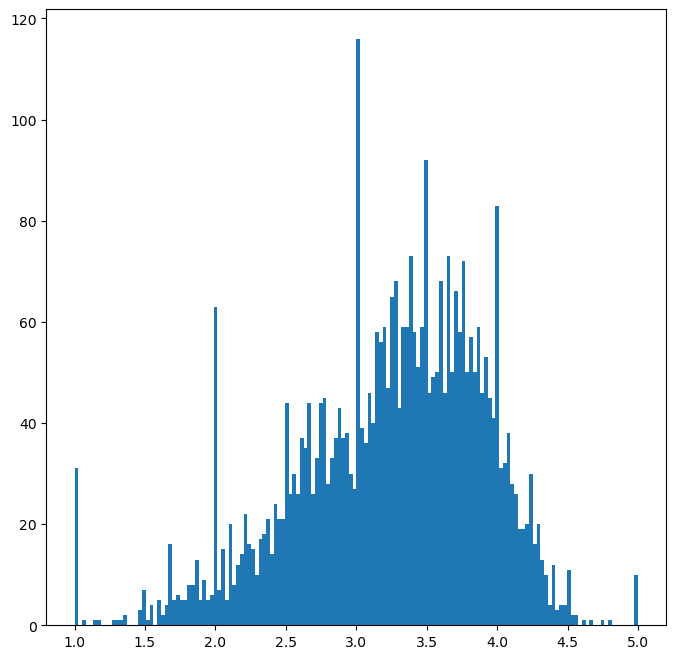

In [33]:
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

In [34]:
merged_data = movie_grouped_rating_info.merge(movie_data, on=['movie_id'], how='left')
merged_data[merged_data['rated_count'] > 100][['rating_mean', 'title']].nlargest(10, 'rating_mean')

,rating_mean,title
1839,4.560510,Seven Samurai (The Magnificent Seven) (Shichin...
309,4.554558,"Shawshank Redemption, The (1994)"
802,4.524966,"Godfather, The (1972)"
708,4.520548,"Close Shave, A (1995)"
49,4.517106,"Usual Suspects, The (1995)"
513,4.510417,Schindler's List (1993)
1066,4.507937,"Wrong Trousers, The (1993)"
861,4.491489,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
1108,4.477725,Raiders of the Lost Ark (1981)
843,4.476190,Rear Window (1954)


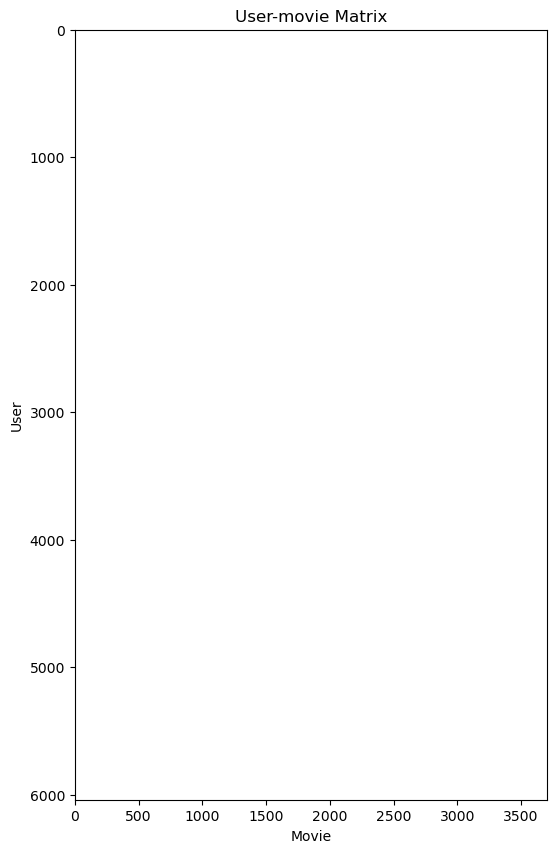

In [35]:
rating_table = rating_data[['user_id', 'movie_id', 'rating']].set_index(["user_id", "movie_id"]).unstack()

plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(rating_table)
plt.grid(False)
plt.xlabel("Movie")
plt.ylabel("User")
plt.title("User-movie Matrix")
plt.show()

In [39]:
!pip install surprise

from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5))

In [40]:
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data = data.build_full_trainset()

In [41]:
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

training time of model: 13.18 seconds


In [42]:
target_user_id = 4
target_user_data = rating_data[rating_data['user_id']==target_user_id]
target_user_data.head(5)

,user_id,movie_id,rating,time
233,4,3468,5,978294008
234,4,1210,3,978293924
235,4,2951,4,978294282
236,4,1214,4,978294260
237,4,1036,4,978294282


In [43]:
target_user_movie_rating_dict = {}

for index, row in target_user_data.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict[movie_id] = row['rating']
            
print(target_user_movie_rating_dict)

{3468: 5, 1210: 3, 2951: 4, 1214: 4, 1036: 4, 260: 5, 2028: 5, 480: 4, 1196: 2, 1198: 5, 1954: 5, 1097: 4, 3418: 4, 3702: 4, 2366: 4, 1387: 5, 3527: 1, 1201: 5, 2692: 5, 2947: 5, 1240: 5}


In [44]:
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    rating = 0
    if movie_id in target_user_movie_rating_dict:
        continue
    test_data.append((target_user_id, movie_id, rating))

In [45]:
target_user_predictions = model.test(test_data)

def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid not in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [46]:
target_user_top10_predicted = sorted(target_user_movie_predict_dict.items(), 
                                     key=operator.itemgetter(1), reverse=True)[:10]

In [47]:
target_user_top10_predicted

[(53, 5),
 (106, 5),
 (326, 5),
 (527, 5),
 (608, 5),
 (615, 5),
 (858, 5),
 (904, 5),
 (908, 5),
 (912, 5)]

In [48]:
movie_dict = {}
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    movie_title = row['title']
    movie_dict[movie_id] = movie_title
    
for predicted in target_user_top10_predicted:
    movie_id = predicted[0]
    predicted_rating = predicted[1]
    print(movie_dict[movie_id], ":", predicted_rating)

Lamerica (1994) : 5
Nobody Loves Me (Keiner liebt mich) (1994) : 5
To Live (Huozhe) (1994) : 5
Schindler's List (1993) : 5
Fargo (1996) : 5
Bread and Chocolate (Pane e cioccolata) (1973) : 5
Godfather, The (1972) : 5
Rear Window (1954) : 5
North by Northwest (1959) : 5
Casablanca (1942) : 5


In [49]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

predictions = model.test(test_data)

print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

training time of model: 23.39 seconds
RMSE of test dataset in SVD model:
RMSE: 0.8615


0.8615011029953593

In [50]:
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    if movie_id in target_user_movie_rating_dict:
        rating = target_user_movie_rating_dict[movie_id]
        test_data.append((target_user_id, movie_id, rating))

In [51]:
target_user_predictions = model.test(test_data)

def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [52]:
target_user_movie_predict_dict

{260: 4.250865391459326,
 480: 3.7196957145669747,
 1036: 4.050687789354861,
 1097: 4.375283103350899,
 1196: 4.002335348363637,
 1198: 4.493129785013774,
 1201: 4.14854164958657,
 1210: 3.6481371106375695,
 1214: 4.276089859813613,
 1240: 4.193609202903161,
 1387: 4.531455407869372,
 1954: 4.308052348741487,
 2028: 4.493128042367919,
 2366: 4.099379077669536,
 2692: 3.892070057563482,
 2947: 4.058774913656739,
 2951: 3.9713316068654403,
 3418: 4.10987232149919,
 3468: 4.560415080536928,
 3527: 3.330464722020019,
 3702: 3.6945847526368105}

In [53]:
origin_rating_list = []
predicted_rating_list = []
movie_title_list = []
idx = 0
for movie_id, predicted_rating in target_user_movie_predict_dict.items():
    idx = idx + 1
    predicted_rating = round(predicted_rating, 2)
    origin_rating = target_user_movie_rating_dict[movie_id]
    movie_title = movie_dict[movie_id]
    print("movie", str(idx), ":", movie_title, "-", origin_rating, "/", predicted_rating)
    origin_rating_list.append(origin_rating)
    predicted_rating_list.append(predicted_rating)
    movie_title_list.append(str(idx))

movie 1 : Star Wars: Episode IV - A New Hope (1977) - 5 / 4.25
movie 2 : Jurassic Park (1993) - 4 / 3.72
movie 3 : Die Hard (1988) - 4 / 4.05
movie 4 : E.T. the Extra-Terrestrial (1982) - 4 / 4.38
movie 5 : Star Wars: Episode V - The Empire Strikes Back (1980) - 2 / 4.0
movie 6 : Raiders of the Lost Ark (1981) - 5 / 4.49
movie 7 : Good, The Bad and The Ugly, The (1966) - 5 / 4.15
movie 8 : Star Wars: Episode VI - Return of the Jedi (1983) - 3 / 3.65
movie 9 : Alien (1979) - 4 / 4.28
movie 10 : Terminator, The (1984) - 5 / 4.19
movie 11 : Jaws (1975) - 5 / 4.53
movie 12 : Rocky (1976) - 5 / 4.31
movie 13 : Saving Private Ryan (1998) - 5 / 4.49
movie 14 : King Kong (1933) - 4 / 4.1
movie 15 : Run Lola Run (Lola rennt) (1998) - 5 / 3.89
movie 16 : Goldfinger (1964) - 5 / 4.06
movie 17 : Fistful of Dollars, A (1964) - 4 / 3.97
movie 18 : Thelma & Louise (1991) - 4 / 4.11
movie 19 : Hustler, The (1961) - 5 / 4.56
movie 20 : Predator (1987) - 1 / 3.33
movie 21 : Mad Max (1979) - 4 / 3.69


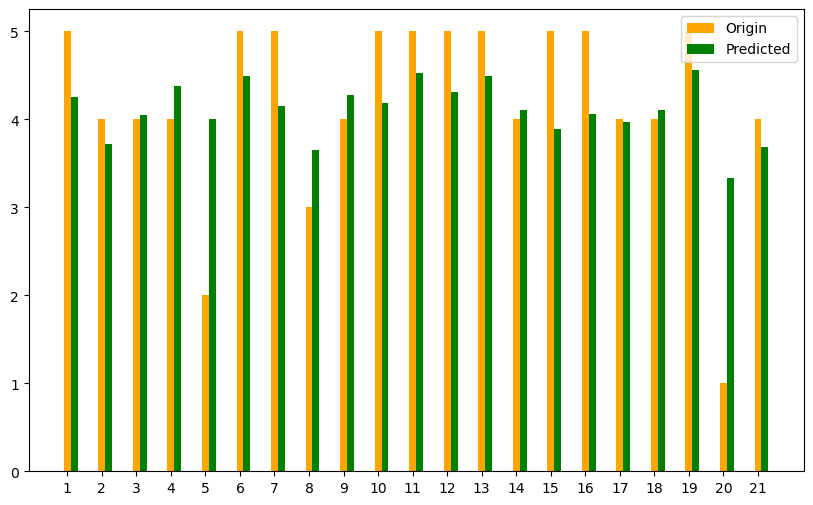

In [54]:
origin = origin_rating_list
predicted = predicted_rating_list
 
plt.rcParams['figure.figsize'] = (10,6)
index = np.arange(len(movie_title_list))
bar_width = 0.2
 
rects1 = plt.bar(index, origin, bar_width,
                 color='orange',
                 label='Origin')
rects2 = plt.bar(index + bar_width, predicted, bar_width,
                 color='green',
                 label='Predicted')
plt.xticks(index, movie_title_list)
plt.legend()
plt.show()